# Exercise 3: Bayes and EM

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Write your functions in this notebook only. **Do not create Python modules and import them**.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. **Do not import anything else.**
6. Answer to the qualitative question should be written in **markdown** cells (with $\LaTeX$ support).

## In this exercise you will perform the following:
1. Implement EM algorithm.
1. Implement Naive Bayes algorithm that uses EM for calculating the likelihood.
1. Visualize your results.

# I have read and understood the instructions: *** YOUR IDS HERE ***

In [128]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [129]:
# Function for ploting the decision boundaries of a model
# You will use it later
def plot_decision_regions(X, y, classifier, resolution=0.01):

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Reading the data

In [130]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values

## Visualizing the data ( 10 points)

Plot the following graphs for the training set:

For the first feature only:
1. For the first 1000 data points plot a histogram for each class on the same graph (use bins=20, alpha=0.5).
1. For all the data points plot a histogram for each class on the same graph (use bins=40, alpha=0.5).

For both features:
1. For the first 1000 data points plot a scatter plot where each class has different color
1. For all the data points plot a scatter plot where each class has different color

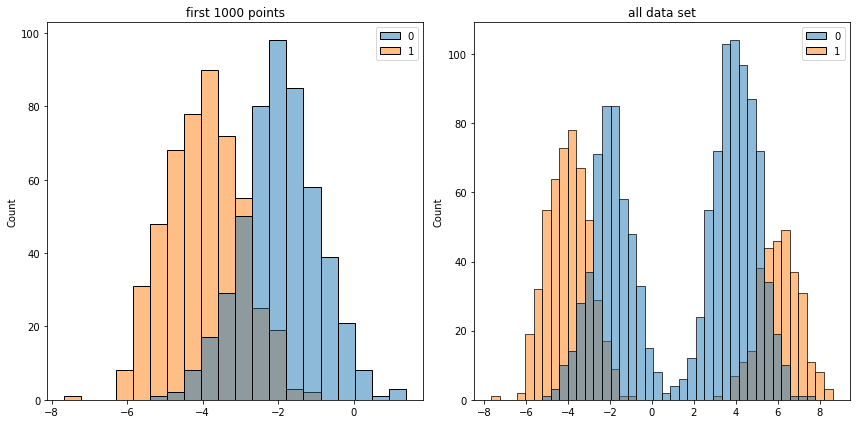

In [131]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)  
sns.histplot(x= X_training[:,0][:1000], hue= y_training[:1000],bins=20, alpha=0.5)
plt.title("first 1000 points")

plt.subplot(1,2,2)  
sns.histplot(x= X_training[:,0], hue=y_training, bins=40, alpha=0.5)
plt.title("all data set")

plt.tight_layout()
plt.show()


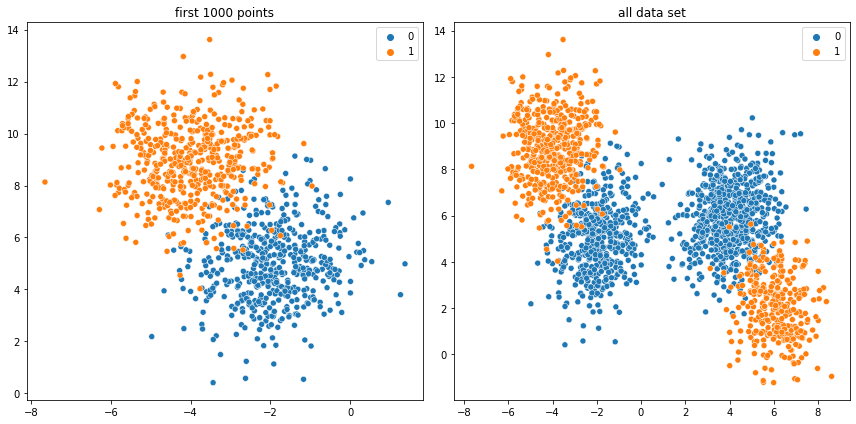

In [132]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)  
sns.scatterplot(x= X_training[:,0][:1000],y= X_training[:,1][:1000], hue=y_training[:1000])
plt.title("first 1000 points")

plt.subplot(1,2,2)  
sns.scatterplot(x= X_training[:,0],y= X_training[:,1], hue=y_training)
plt.title("all data set")

plt.tight_layout()
plt.show()


## Normal distribution pdf (10 Points)

Implement the normal distribution pdf 
$$
f(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\big{(}\frac{x-\mu}{\sigma}\big{)}^2}
$$
Write efficient vectorized code

In [133]:
#### Your code here ####
# calc normal pdf    
def norm_pdf(data, mu, sigma):
    pdf = (1/(sigma*np.sqrt(2*np.pi))) * np.exp(-0.5*((data-mu)/sigma)**2)
    return pdf

## Expectation Maximization (30 Points)

Implement the Expectation Maximization algorithm for gaussian mixture model.

The class should hold the distribution params.

Use negative log likelihood as the cost function:
$$
cost(x) = \sum_{i=1}^{m}-log\bigg(\sum_{j=1}^{k}w_j * pdf(x_i; \mu_j, \sigma_j)\bigg)
$$

\* Where i is the index of the instances (from 1 to m) and j is the index of the gaussian in the GMM (from 1 to k). 

Your class should contain the following functions:
1. init_params - initialize distribution params
1. expectation - calculating responsibilities
1. maximization - updating distribution params
1. fit - the learning function (this function calls the init_params and then iteratively calls expectation and maximization)
1. get_dist_params - return the params of the distribution (the GMM distribution) 

\* You can add more functions if you think this is necessary

Don't change the eps params (eps=0.01)

When you need to calculate the pdf of a normal distribution use the function `norm_pdf` that you implemented above.

In [134]:
class EM(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    n_iter : int
      Passes over the training dataset in the EM proccess
    eps: float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1, n_iter=1000, eps=0.01):
        self.k = k
        self.n_iter = n_iter
        self.eps = eps

    # initial guesses for parameters
    def init_params(self, data):
        """
        Initialize distribution params
        """
        self.ws = np.full(self.k, 1.0 / self.k)
        self.mus = []
        self.sigmas = []
        # Guess mu as center of K quantiles
        quat_data, bins = pd.qcut(data, self.k, retbins=True, labels=False)
        self.mus = (bins[:-1] + bins[1:]) / 2
        # Guess sigma as empiric sigma
        self.sigmas = np.array([np.sqrt(np.mean((data[quat_data == k] - self.mus[k]) ** 2)) for k in range(self.k)])

    def expectation(self, data):
        """
        E step - calculating responsibilities
        """
        x = data.reshape(-1,1)
        numerator = self.ws*norm_pdf(x,self.mus,self.sigmas)
        denominator = numerator.sum(axis=1)
        responsibilities = numerator/denominator.reshape(-1,1)
        
        self.res = responsibilities

    def maximization(self, data):
        """
        M step - updating distribution params
        """
        new_ws = self.res.mean(axis=0)
        new_mus = (self.res * data.reshape(-1,1)).mean(axis=0) / new_ws
        new_sigmas = np.sqrt((np.power(data.reshape(-1,1) - new_mus,2)*self.res).mean(axis=0)/new_ws)
        
        self.ws = new_ws
        self.mus = new_mus
        self.sigmas = new_sigmas

    def fit(self, data):
        """ 
        Fit training data (the learning phase).
        Use init_params and then expectation and maximization function in order to find params 
        for the distribution. 
        Store the params in attributes of the EM object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        """
        self.init_params(data)
        
        # compute the cost for the initial values
        costs = [self.compute_cost(data)]
        
        for i in range(self.n_iter):
            # Expectation
            self.expectation(data)
            
            # Maximization
            self.maximization(data)
            
            # compute the new cost after updating the values
            costs.append(self.compute_cost(data))

            # break if the difference in costs is smallet than eps
            if abs(costs[-1] - costs[-2]) < self.eps:
                break

    def get_dist_params(self):
        return self.ws, self.mus, self.sigmas
    
    def compute_cost(self,data):
        cost = (-np.log((norm_pdf(data.reshape(-1,1), self.mus,self.sigmas)*self.ws).sum(axis=1))).sum()
        return cost

## Naive Bayes (30 Points)

Implement the Naive Bayes algorithm.

For calculating the likelihood use the EM algorithm that you implemented above to find the distribution params. With these params you can calculate the likelihood probability.

Calculate the prior probability directly from the training set.

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance (or instances) after the fit function was executed

\* You can add more functions if you think this is necessary


In [135]:
class NaiveBayesGaussian(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1):
        self.k = k

    def fit(self, X, y):
        """ 
        Fit training data.

        Parameters
        ----------
        X : array-like, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        """
        self.gaussian_parameters = [] # store ws, mus and sigmas for each class
        self.priors = self.get_priors(y)
        self.y_unique = np.unique(y)
        
        for y_val in np.unique(y):
            for feature in range(X.shape[1]):
                em = EM(k= self.k)
                em.fit(X[:,feature][y == y_val])
                self.gaussian_parameters.append(em.get_dist_params())
                
    def get_priors(self,y):
        # Get unique values and their counts
        unique_values, counts = np.unique(y, return_counts=True)
        priors = counts / y.size
        
        return priors
    

    def predict(self, X):
        """Return the predicted class label"""
        
        liklihood_in_each_class = [] # list that store the postiriors of each instance by each class P(instance|class)
        k=0 # counter to get the right gaussian paramters
        
        # itirate over the number of 
        for j in range(len(nb.y_unique)):
            liklihood = np.ones(X.shape[0]) # initiate postirior for each class
            
            # itirate over the number of feature
            for i in range(X.shape[1]):
                
                # get the corrrect set of guassian paramters from the list
                ws, mus, sigmas = self.gaussian_parameters[k] 
                
                # we assumed independency so p(instance|class) = p(x0|c) *p(x1|c)....
                liklihood *= (ws* norm_pdf(X[:,i].reshape(-1,1),mus,sigmas)).sum(axis=1) 
                
                k+=1 
                
            liklihood_in_each_class.append(liklihood)
            
        # we want to see the postirior of the instance in each class next to each other to predict
        postiriors = np.transpose(liklihood_in_each_class)* self.priors
        
        # prediction
        pred = np.argmax(postiriors,axis=1)
        
        return pred

## Model evaluation (10 points)

1. Use the first 1000 points from the training set (take the first original 1000 points - before the shuffle) and the first 500 points from the test set.
1. Fit the Naive Bayes model. Remember that you need to select the number of Gaussians in the EM.
1. Print the training and test accuracies for the model.
1. Use the `plot_decision_regions` function to plot the decision boundaries for the model (for this you need to use the training set as the input)

Use all the training set points:
1. Repeat sections 2-4 for all the training set points

Training accuracy: 0.968
Test accuracy: 0.942


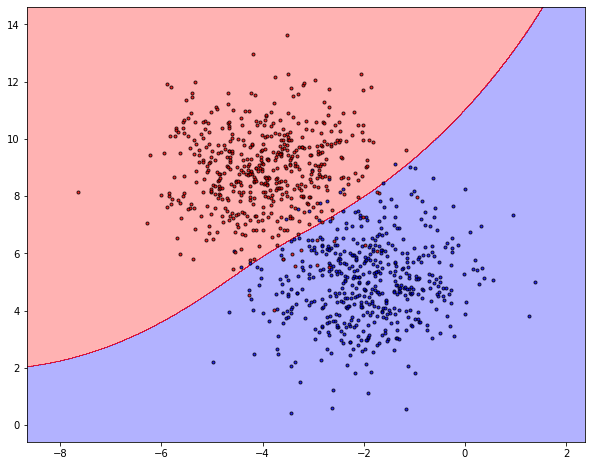

In [136]:
from sklearn.metrics import accuracy_score

# create model
nb = NaiveBayesGaussian(k= 2)

# fit
nb.fit(X_training[:1000],y_training[:1000])

y_pred_train = nb.predict(X_training[:1000])  # predict -train
y_pred_test = nb.predict(X_test[:500]) # predict -test

# Compute training accuracy
train_accuracy = accuracy_score(y_training[:1000], y_pred_train)

# Compute test accuracy
test_accuracy = accuracy_score(y_test[:500], y_pred_test)

print("Training accuracy:", train_accuracy)
print("Test accuracy:", test_accuracy)

plot_decision_regions(X_training[:1000],y_training[:1000],nb)

Training accuracy: 0.9215
Test accuracy: 0.902


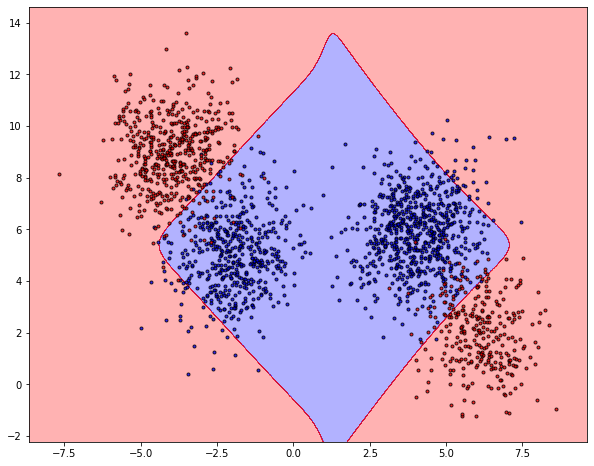

In [137]:
# create model
nb = NaiveBayesGaussian(k= 2)

# fit
nb.fit(X_training,y_training)

y_pred_train = nb.predict(X_training)  # predict -train
y_pred_test = nb.predict(X_test) # predict -test

# Compute training accuracy
train_accuracy = accuracy_score(y_training, y_pred_train)

# Compute test accuracy
test_accuracy = accuracy_score(y_test, y_pred_test)

print("Training accuracy:", train_accuracy)
print("Test accuracy:", test_accuracy)

plot_decision_regions(X_training,y_training,nb)

## Open question (10 points) 

In the previous course we implemented the Logistic regression algorithm and we have now completed the implementation of Naive Bayes using EM. 

- Generate one dataset that you think Naive Bayes will work better than Logistic Regression.
- Generate another dataset that you think Logistic Regression will work better than Naive Bayes using EM.
- Explain the reasoning behind each dataset.  

(The number of features and instances is up to you, but use only 2 classes)

2. Visualize the datasets like in the beginning of this notebook.

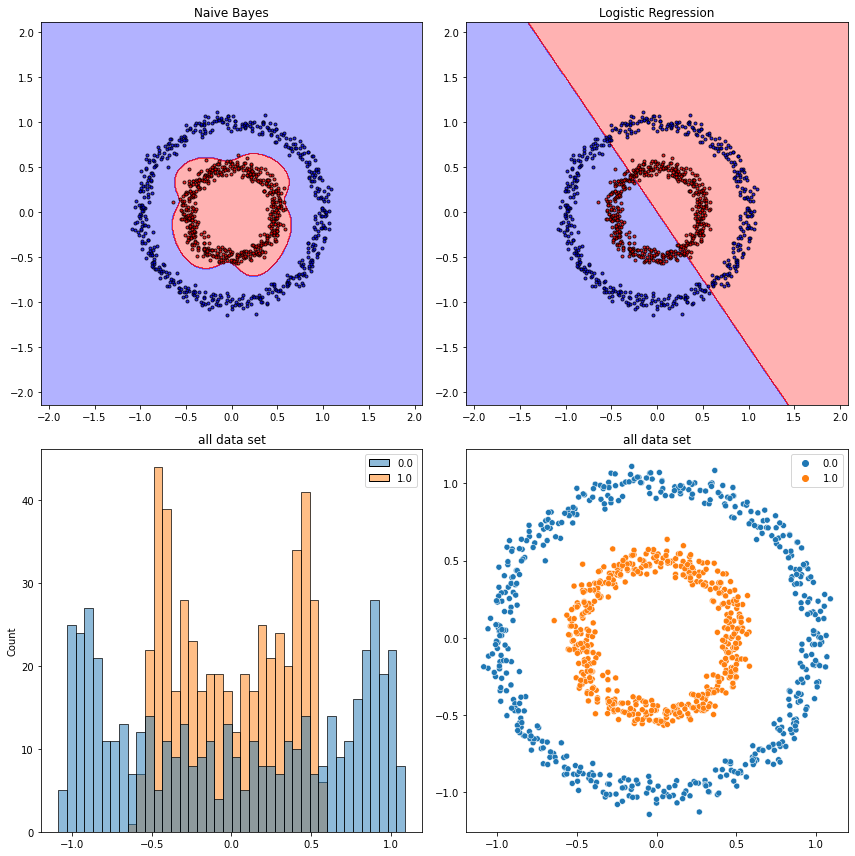

In [138]:
# Generate circle data
N = 1000  # number of data points
X, y = make_circles(n_samples=N, factor=.5, noise=.05)

# Combine X and y
data = np.column_stack((X, y))

data_x = data[:,:2]
data_y = data[:,2]

nb2 = NaiveBayesGaussian(k=2)
nb2.fit(data_x,data_y)

lr = LogisticRegressionGD()
lr.fit(data_x,data_y)

# Creating subplots
plt.figure(figsize=(12,12))

plt.subplot(2,2,1)  # 1 row, 2 columns, first subplot
plot_decision_regions(data_x,data_y,nb2)
plt.title('Naive Bayes')

plt.subplot(2,2,2)  # 1 row, 2 columns, second subplot
plot_decision_regions(data_x,data_y,lr)
plt.title('Logistic Regression')

plt.subplot(2,2,3)  
sns.histplot(x= data_x[:,0], hue=data_y, bins=40, alpha=0.5)
plt.title("all data set")

plt.subplot(2,2,4)  
sns.scatterplot(x= data_x[:,0],y= data_x[:,1], hue=data_y)
plt.title("all data set")

plt.tight_layout()
plt.show()


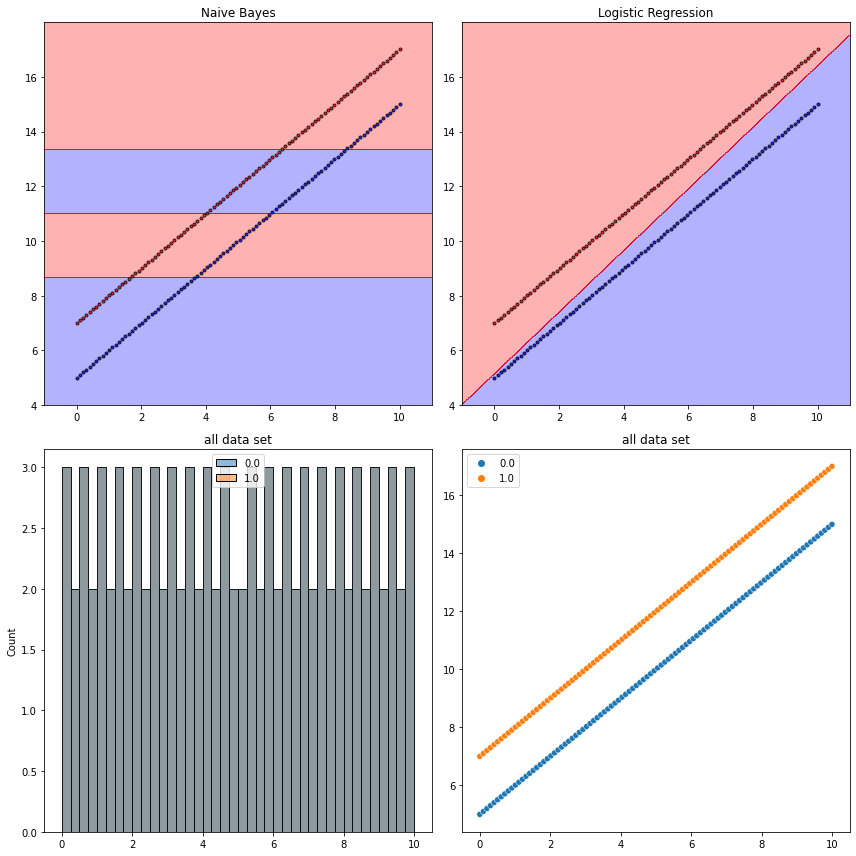

In [139]:
import numpy as np

# Define the range of x-values
x = np.linspace(0, 10, 100)

# Use the equations of the lines to calculate the y-values
y1 = x + 5
y2 = x + 7

# Create labels for the two classes
labels1 = np.zeros(len(x))  
labels2 = np.ones(len(x))   

# Combine x-values, y-values, and labels into a single array
data1 = np.column_stack((x, y1, labels1))
data2 = np.column_stack((x, y2, labels2))

# Concatenate the data from the two classes
data = np.concatenate((data1, data2), axis=0)

data_x = data[:,:2]
data_y = data[:,2]

nb2 = NaiveBayesGaussian(k=2)
nb2.fit(data_x,data_y)

lr = LogisticRegressionGD()
lr.fit(data_x,data_y)

# Creating subplots
plt.figure(figsize=(12,12))

plt.subplot(2,2,1)  # 1 row, 2 columns, first subplot
plot_decision_regions(data_x,data_y,nb2)
plt.title('Naive Bayes')

plt.subplot(2,2,2)  # 1 row, 2 columns, second subplot
plot_decision_regions(data_x,data_y,lr)
plt.title('Logistic Regression')

plt.subplot(2,2,3)  
sns.histplot(x= data_x[:,0], hue=data_y, bins=40, alpha=0.5)
plt.title("all data set")

plt.subplot(2,2,4)  
sns.scatterplot(x= data_x[:,0],y= data_x[:,1], hue=data_y)
plt.title("all data set")

plt.tight_layout()
plt.show()



In [140]:
# You are provided with the Logistic regression class if you need it

class LogisticRegressionGD(object):
    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    eps : float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random weight
      initialization.
    """
    
    def __init__(self, eta=0.00005, n_iter=10000, eps=0.000001, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state

    def fit(self, X, y):
        """ 
        Fit training data (the learning phase).
        Updating the theta vector in each iteration using gradient descent.
        Store the theta vector in an attribute of the LogisticRegressionGD object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        """
        rgen = np.random.RandomState(self.random_state)
        self.theta = np.random.normal(loc=0.0, scale=1, size=1 + X.shape[1])
        self.cost = []
        old_cost = 0
        output = []
        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (output - y)
            self.theta[1:] -= self.eta * X.T.dot(errors)
            self.theta[0] -= self.eta * errors.sum()
            # note that we compute the logistic `cost` now
            # instead of the sum of squared errors cost
            cost = (-y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output)))).sum() / X.shape[0]
            if abs(cost - old_cost) < self.eps:
                break
            old_cost = cost
            self.cost.append(cost)
    
    def predict(self, X):
        """Return the predicted class label"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.theta[1:]) + self.theta[0]

    def activation(self, z):
        """Compute logistic sigmoid activation"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))


#### Your answer here ####


In the first plot the naive bayes does better than the logistic regression since there is no way to create a linear separator,  there are 2 clearly seperate distributions along the x and y axis that the EM can easily separate.

In the second plot the logistioc regression find linear separator easily but the distribuition along the first and second feature are overlapping.